<a href="https://colab.research.google.com/github/Krishnaa548/Data_privacy_security/blob/main/Federated_learning_dps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 602kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.86MB/s]

Federated Learning Round 1/5


Client 1 Accuracy: 0.8987
Client 2 Accuracy: 0.9002
Client 3 Accuracy: 0.8991
Global Model Test Accuracy: 0.8459

Federated Learning Round 2/5
Client 1 Accuracy: 0.9153
Client 2 Accuracy: 0.9143
Client 3 Accuracy: 0.9140
Global Model Test Accuracy: 0.8183

Federated Learning Round 3/5
Client 1 Accuracy: 0.9238
Client 2 Accuracy: 0.9209
Client 3 Accuracy: 0.9217
Global Model Test Accuracy: 0.8165

Federated Learning Round 4/5
Client 1 Accuracy: 0.9323
Client 2 Accuracy: 0.9304
Client 3 Accuracy: 0.9280
Global Model Test Accuracy: 0.7603

Federated Learning Round 5/5
Client 1 Accuracy: 0.9322
Client 2 Accuracy: 0.9377
Client 3 Accuracy: 0.9323
Global Model Test Accuracy: 0.7966



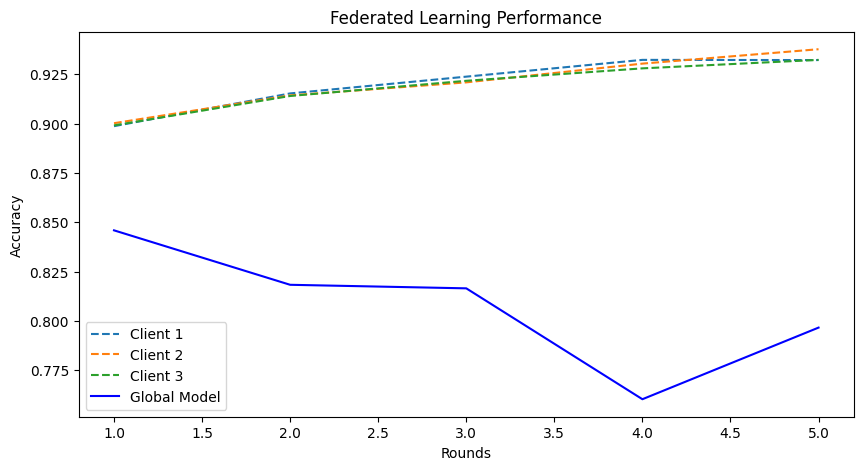

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):  # Fixed: Changed _init_ to __init__
        super(Net, self).__init__()  # Fixed: Changed _init_ to __init__
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def fed_avg(models):
    global_model = Net().to(device)
    global_state_dict = global_model.state_dict()

    for key in global_state_dict.keys():
        global_state_dict[key] = torch.mean(
            torch.stack([model.state_dict()[key].float() for model in models]), dim=0
        )

    global_model.load_state_dict(global_state_dict)
    return global_model

def train(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

train_dataset, test_dataset = get_data()
num_clients = 3
client_datasets = np.array_split(range(len(train_dataset)), num_clients)
train_loaders = [DataLoader(Subset(train_dataset, indices), batch_size=32, shuffle=True, num_workers=2) for indices in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

models = [Net().to(device) for _ in range(num_clients)]
optimizers = [optim.SGD(model.parameters(), lr=0.01) for model in models]
criterion = nn.CrossEntropyLoss()

rounds = 5
client_accuracies = [[] for _ in range(num_clients)]
global_accuracies = []

for r in range(rounds):
    print(f'Federated Learning Round {r+1}/{rounds}')
    for i, model in enumerate(models):
        train(model, train_loaders[i], criterion, optimizers[i], epochs=1)
        acc = test(model, test_loader)
        client_accuracies[i].append(acc)
        print(f'Client {i+1} Accuracy: {acc:.4f}')

    global_model = fed_avg(models)
    global_acc = test(global_model, test_loader)
    global_accuracies.append(global_acc)
    print(f'Global Model Test Accuracy: {global_acc:.4f}\n')

plt.figure(figsize=(10,5))
for i in range(num_clients):
    plt.plot(range(1, rounds+1), client_accuracies[i], linestyle='dashed', label=f'Client {i+1}')
plt.plot(range(1, rounds+1), global_accuracies, color='blue', label='Global Model')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Federated Learning Performance')
plt.savefig('federated_learning_performance.png')  # Save the plot to include in your PDF
plt.show()
